In [1]:
import yfinance as yf
import pandas as pd
import sys
import numpy as np
from numpy.linalg import inv
import json
from sklearn.preprocessing import MinMaxScaler

sys.path.append('../')

import data_generation

In [2]:
data = yf.download(['AAPL','GOOG','AMZN','INTC','BA','FDX'], start='2009-08-05', end='2010-08-01', progress=False)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
returns

Ticker,AAPL,AMZN,BA,FDX,GOOG,INTC
Date,,,,,,
2009-08-06 00:00:00+00:00,-0.007267,0.002135,0.033841,-0.014989,-0.001729,-0.008484
2009-08-07 00:00:00+00:00,0.009761,0.010063,0.025703,0.022450,0.014966,-0.010695
2009-08-10 00:00:00+00:00,-0.004773,-0.010314,-0.019704,-0.010905,-0.001072,0.014055
2009-08-11 00:00:00+00:00,-0.011474,-0.010422,-0.008303,-0.017134,-0.005847,-0.006397
2009-08-12 00:00:00+00:00,0.015231,0.028722,0.020930,0.006215,0.010222,0.009120
...,...,...,...,...,...,...
2010-07-26 00:00:00+00:00,-0.002539,-0.003954,0.013543,0.056104,-0.002224,0.000922
2010-07-27 00:00:00+00:00,0.018513,-0.010726,-0.003340,-0.012232,0.007485,-0.005988
2010-07-28 00:00:00+00:00,-0.011815,0.000000,-0.018945,0.005706,-0.016808,-0.011584


In [3]:
freq=5
size=20
start=0
end=start+size
data_splits=[]
dates=[]
while end < len(returns):
    data_splits.append(returns.iloc[start:end])
    dates.append(returns.index[start])
    start=start+freq
    end=start+size


In [4]:
len(data_splits)

46

In [5]:
S = []
n_list = []
T=len(data_splits)

for i in range(T):
    segment = data_splits[i]
    n_i = segment.shape[0]
    n_list.append(n_i)
    # Empirical covariance. Use rowvar=False so each column is a variable
    cov_i = np.cov(segment, rowvar=False)
    S.append(cov_i)

In [6]:
from tvgl_solver import *

lambda_ = 2  # L1 regularization (sparsity)
beta = 0.1 # Smoothness regularization
Thetas_estimated =solve_time_varying_graphical_lasso(
    S=S,
    n_list=n_list,
    lambda_=lambda_,
    beta=beta,
    penalty_function=element_wise,
    p=6,
    T=T
)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 25 03:22:47 PM: Your problem has 1656 variables, 1656 constraints, and 0 parameters.
(CVXPY) Jan 25 03:22:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 25 03:22:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 25 03:22:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 25 03:22:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 25 03:22:47 PM: Compiling problem (target solver=SCS).


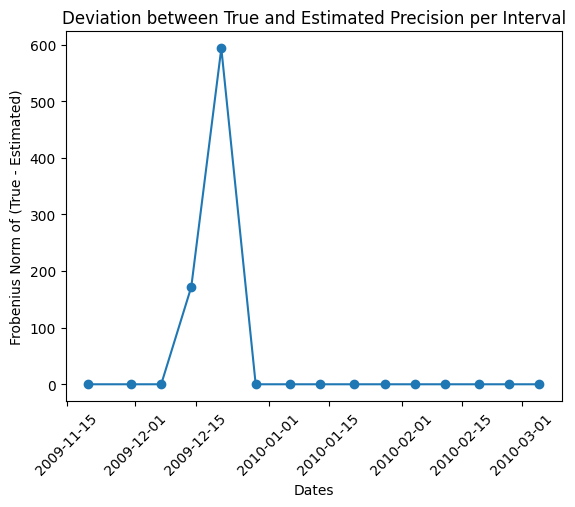

In [7]:
import matplotlib.pyplot as plt

start_index =  15
end_index = 30 

# Compute deviations as before
deviations = [np.linalg.norm(Thetas_estimated[i] - Thetas_estimated[i-1], ord='fro') for i in range(1, len(Thetas_estimated))]

# Slice dates and deviations based on the desired indices
sliced_dates = dates[start_index:end_index]
sliced_deviations = deviations[start_index-1:end_index-1]

# Plot the sliced data
plt.plot(sliced_dates, sliced_deviations, marker='o')
plt.xlabel("Dates")
plt.xticks(rotation=45)
plt.ylabel("Frobenius Norm of (True - Estimated)")
plt.title("Deviation between True and Estimated Precision per Interval")
plt.show()
